b
1
c
1
b
3
Canvas Created
c


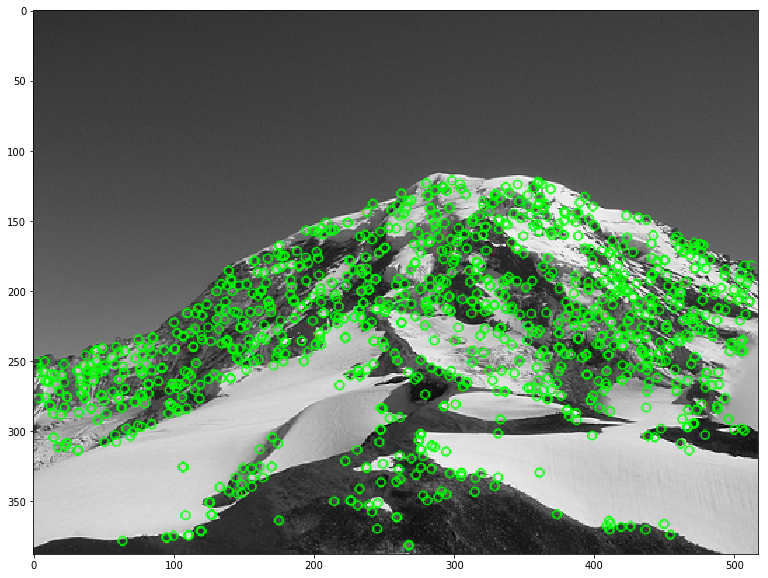

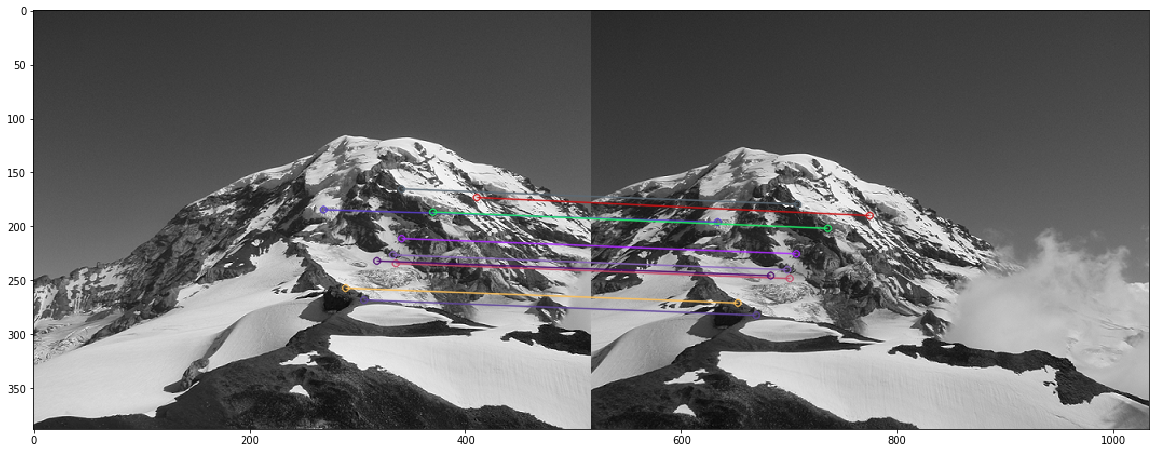

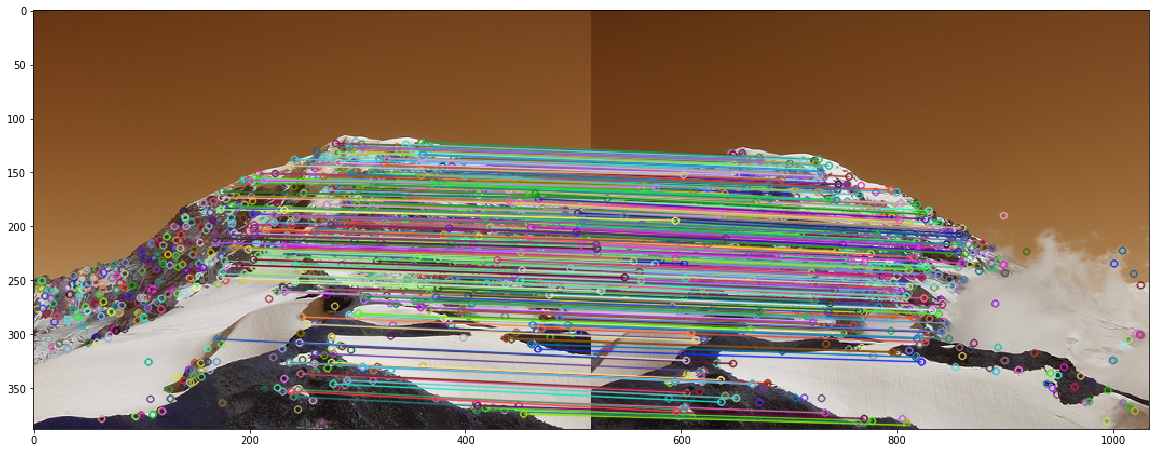

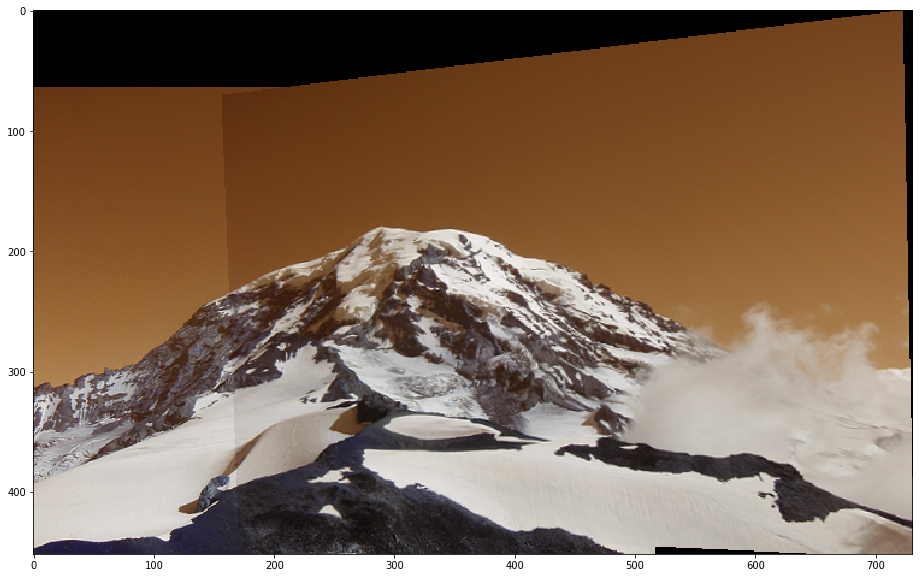

In [4]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

sift = cv2.xfeatures2d.SIFT_create()    
np.seterr(divide="ignore",invalid="ignore")


def load_img(a):
    img = cv2.imread(a)
    return img

def display_img(img,cmap=None):
    plt.figure(figsize=(20,10))
    plt.imshow(img,cmap)

    
def starts(image1,image2):
    img=image1
    img2 = image2
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    kp,des=calculate_kp_des(gray,img)
    kp2,des2=calculate_kp_des(gray2,img2)
    return img,img2,gray,gray2,kp,des,kp2,des2

def project(x1,y1,H):
        u, v, w = np.dot(H, np.array([x1, y1, 1], np.float32))
        x2, y2 = u / w, v / w
        return u / w, v / w



def computeInlierCount(H,matches,inlierThreshold,kp,kp2):
    x=[]
    src_pts = np.float32([kp[match.queryIdx].pt for match in matches])
    dst = np.float32([kp2[match.trainIdx].pt for match in matches])
    for i in range(0,len(src_pts)):
        x1, y1 = src_pts[i]
        temp = np.array([x1, y1, 1], np.float32)
        u, v, w = np.dot(H, temp)
        x2, y2 = u / w, v / w
        a=((dst[i][0]-x2)**2+(dst[i][1]-y2)**2)**.5
        if a < inlierThreshold:
            x.append(i)
            
    return x

    
# Calculating keypoins using Harris Corner and descriptor using sift
def calculate_kp_des(img,org):
    points = cv2.cornerHarris(img, 2, 3, 0.04) #calculate response
    temp = org.copy()
    dst = cv2.dilate(points,None)
    temp[dst>0.01*dst.max()]=[0,0,255]
    # Threshold 
    kp = np.argwhere(points > 0.01 * points.max())
    kp = [cv2.KeyPoint(x[1], x[0], 1) for x in kp]
    kp,des = sift.compute(img,kp) #for testing
    kp, des = sift.detectAndCompute(img,None)
    return kp,des

# Stiching Function

def stitch2(img, img2,Hnew,inverse):
    #co_ordsImg1,old_cods=co_ordinates(img,img2,inverse)

    co_ordsImg1 = []
    co_ordsImg1.append((0, 0))
    co_ordsImg1.append((img.shape[1], 0))
    co_ordsImg1.append((0, img.shape[0]))
    co_ordsImg1.append((img.shape[1], img.shape[0]))
    old_cods=[]
    old_cods.append(( 0,0))
    old_cods.append(( img2.shape[1],0))
    old_cods.append(( 0,img2.shape[0]))
    old_cods.append(( img2.shape[1],img2.shape[0]))
    co_ordsImg2=[]
    for i in range(0,4):
        x2,y2=project(old_cods[i][0],old_cods[i][1],inverse)
        co_ordsImg2.append((x2,y2))
    xImg1Old,yImg1Old=co_ordsImg1[0]
    xImg1New,yImg1New=co_ordsImg1[3]
    xstart=0
    ystart=0
    xmax=img.shape[1]
    ymax=img.shape[0]

    for i in range(0,4):
        if xImg1Old > co_ordsImg2[i][0] :
            xmax=int(round(xmax+xImg1Old-co_ordsImg2[i][0],0))
            xstart=int(round(xImg1Old - co_ordsImg2[i][0],0))
            print("a")
            print(i)
        if  xImg1New<co_ordsImg2[i][0] and co_ordsImg2[i][0]>xmax:
            xmax=int(round(co_ordsImg2[i][0],0))
            print("b")
            print(i)
        if yImg1Old>co_ordsImg2[i][1]:
            ymax=int(round(ymax+yImg1Old-co_ordsImg2[i][1],0))
            ystart=int(round(yImg1Old-co_ordsImg2[i][1],0))
            print("c")
            print(i)
        if   yImg1New<co_ordsImg2[i][1]and co_ordsImg2[i][1]>ymax:
            ymax=int(round(co_ordsImg2[i][1],0))
            print("d")
            print(i)
    xImg2Old, yImg2Old = old_cods[0]
    xImg2New, yImg2New = old_cods[3]
    emptyCanvas=np.empty((ymax,xmax,3))
    print("Canvas Created")
    try:
        for i in range(img.shape[1]):
            for j in range(img.shape[0]):
                emptyCanvas[ystart+j][xstart+i]=img[j][i]

    except:
        print("Error Copying in Image 1")
   
    
    for i in range(emptyCanvas.shape[1]):
        for j in range(emptyCanvas.shape[0]):
            x2,y2=project(i-xstart,j-ystart,Hnew)
            if x2>xImg2Old and x2<xImg2New and y2>yImg2Old and y2<yImg2New :
                emptyCanvas[j][i]=cv2.getRectSubPix(img2,(1,1),(x2,y2))

    emptyCanvas=np.uint8(emptyCanvas)    
    return emptyCanvas

def main():

    numIterations=500
    inlierThreshold=.75
    image1="project_images/Rainier1.png"
    image2="project_images/Rainier2.png"
    emptyCanvas = cv2.imread(image1)
    emptyCanvas2 = cv2.imread(image2)
    #https://dsp.stackexchange.com/questions/24346/difference-between-feature-detector-and-descriptor
    img, img2, gray, gray2, kp, des, kp2, des2 = starts(emptyCanvas, emptyCanvas2)
    #display_img(gray2)
    imgx=cv2.drawKeypoints(gray,kp,gray,color=(0,255,0))
    display_img(imgx)
    # create BFMatcher object
    bf = cv2.BFMatcher(crossCheck=True)
    # descriptors.
    matches = bf.match(des,des2)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # Draw matches.
    img3 = cv2.drawMatches(gray,kp,gray2,kp2,matches[:10], gray2,flags=2)
    display_img(img3)
    #https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html
    h=[]
    for i in range(0,500):
        randoms=[]
        for j in range(0,4):
            randoms.append(random.choice(matches))
        src_pts = np.float32( [kp[match.queryIdx].pt for match in randoms])
        dst_pts = np.float32( [kp2[match.trainIdx].pt for match in randoms])
        H, mask = cv2.findHomography(src_pts, dst_pts,0)
        x=computeInlierCount(H,matches,inlierThreshold,kp,kp2)

        h.append((len(x),x))
    h.sort( reverse=True)
    h=h[0][1]
    
    
    new_matches=[]
    new_kp=[]
    new_kp2=[]
    for i in  h:
        new_matches.append(matches[i])
        
    a = np.float32( [kp[match.queryIdx].pt for match in new_matches])
    b = np.float32( [kp2[match.trainIdx].pt for match in new_matches])
    H, mask = cv2.findHomography(a, b,0)
    inverse = np.linalg.inv(H)
    imgx3 = cv2.drawMatches(img,kp,img2,kp2,new_matches,img2)
    display_img(imgx3)
    emptyCanvas= stitch2(img,img2,H,inverse)

    display_img(emptyCanvas)
    print("c")
main()

In [2]:
print("c")

c
